
## Load Face and Non-Face Datasets

- The datasets used:  
    - Labelled Faces in the Wild: A dataset of face photographs mainly used for studying the unconstrained face recognition problem. This dataset will be used as the face dataset.
    - Caltech-256: A dataset of objects in 257 categories. This dataset will be used as the non-face dataset.
    
- It is important to note that since some of the categories in the Caltech-256 dataset such as *205.superman*, *253.faces-easy-101*, etc contain faces, to improve the non-face dataset these faulty categories are removed from the non-face dataset.

- Note that the images themselves aren't loaded, but rather the path to them is loaded to conserve the main memory usage during the runtime.

In [1]:
import os
import cv2
import numpy as np
import sklearn

def load_loc(path, remove_labels = []):
    labels = os.listdir(path)
    path_data = []
    for label in labels:
        os.listdir(path + label)
        if label in remove_labels:
            continue;
        for im_name in os.listdir(path + label):
            if ".jpg" in im_name:
                path_data.append(path + label + "/" + im_name)
    return np.array(path_data)

np.random.seed(0)
data_loc_pos = load_loc("./data/lfw/")
data_loc_neg = load_loc("./data/256_ObjectCategories/", ["011.billiards", 
                                                     "022.buddha-101", 
                                                     "032.cartman",
                                                    "119.jesus-christ",
                                                    "159.people",
                                                    "232.t-shirt",
                                                    "205.superman",
                                                   "253.faces-easy-101"])
np.random.shuffle(data_loc_neg)

## Train, Test, and Validation Split

Each dataset is split into train, validation, and test datasets, where the size of each of the validation and test datasets is 1000, and the size of the training dataset is 10000. The final train, validation, and test dataset is the result of the concatenation of positive (face) and negative (non-face) samples in their respective datasets.

In [2]:
def get_train_val_test(data):
    test_index= np.random.choice(len(data), 1000, replace= False)
    test = data[test_index]
    data = np.delete(data, test_index)
    val_index= np.random.choice(len(data), 1000, replace= False)
    val = data[val_index]
    data = np.delete(data, val_index)
    train_index= np.random.choice(len(data), 10000, replace= False)
    train = data[train_index]
    return train, val, test

train_loc_pos, val_loc_pos, test_loc_pos = get_train_val_test(data_loc_pos)
train_loc_neg, val_loc_neg, test_loc_neg = get_train_val_test(data_loc_neg)

train_loc_x = np.concatenate((train_loc_pos, train_loc_neg))
train_y = np.concatenate((np.ones(10000), np.ones(10000) * -1))
val_loc_x = np.concatenate((val_loc_pos, val_loc_neg))
val_y = np.concatenate((np.ones(1000), np.ones(1000) * -1))
test_loc_x = np.concatenate((test_loc_pos, test_loc_neg))
test_y = np.concatenate((np.ones(1000), np.ones(1000) * -1))

## Get Feature Vectors

To extract feature vectors for each input image, a **HOG descriptor** is used. These feature vectors are then used to train a **SVM**.

In [3]:
def get_feature(data_loc, hog):
    features = []
    for data in data_loc:
        im = cv2.resize(cv2.imread(data, -1), hog.winSize)
        features.append(hog.compute(im))
    features = np.array(features)
    return features.reshape(features.shape[:2])

## Obtain the Best Parameters

To evaluate different model parameters and obtain the best possible ones, train and validation sets are used. For each set of parameters, the model is first trained on the training set and then evaluated on the validation set. The best performing parameters on the validation set are used as the parameters for the final model.

This validation process is used to determine the best parameters for the **HOG descriptor** and **SVM classifier**.

### Validation on HOG descriptor

- Three hyperparameters are chosen for the HOG descriptor, using the following possible values:
    - window size : (64, 64) and (128, 128)
    - block size : (16, 16) and (32, 32)
    - cell size : (8, 8) and (16, 16)
    
- The SVM classifier's hyperparameters are set to the following values:
    - c : 1
    - kernel : rbf

In [4]:
from sklearn.svm import SVC

def print_setting_svm(setting):
    print("window size: " + str(setting[0]) + 
          " block size: " + str(setting[1]) + 
         " cell size: " + str(setting[2]))

def accuracy(pred_y, true_y):
    return np.sum(pred_y == true_y) / len(true_y) * 100

def val_HOG(train_loc_x, train_y, test_loc_x, test_y, wss = [128], bss = [16], 
            css = [8], cs = [0], kernels=["rbf"]):
    best_accuracy = 0
    best_setting = [0, 0, 0]
    best_pred = None
    for ws in wss:
        win_size = (ws,ws)
        for bs in bss:
            block_size = (bs, bs)
            for cell in css:
                block_stride = (cell, cell)
                cell_size = (cell, cell)
                hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, 9)
                train_x = get_feature(train_loc_x, hog)
                test_x = get_feature(test_loc_x, hog)
                for c in cs:
                    c = 10 ** c
                    for kernel in kernels:
                        SVM = SVC(C=c, kernel=kernel)
                        SVM.fit(train_x, train_y)
                        pred_y = SVM.predict(test_x)
                        if accuracy(pred_y, test_y) > best_accuracy:
                            best_accuracy = accuracy(pred_y, test_y)
                            best_setting = [ws, bs, cell]
                            best_pred = pred_y
                        print_setting_svm([ws, bs, cell])
                        print(accuracy(pred_y, test_y))
    print("Best Setting:")
    print_setting_svm(best_setting)
    print(best_accuracy)
    return best_pred

best_pred = val_HOG(train_loc_x, train_y, val_loc_x, val_y, wss=[64, 128], bss=[16, 32], css=[8, 16])

window size: 64 block size: 16 cell size: 8
99.65
window size: 64 block size: 16 cell size: 16
96.55
window size: 64 block size: 32 cell size: 8
99.65
window size: 64 block size: 32 cell size: 16
99.35000000000001
window size: 128 block size: 16 cell size: 8
99.8
window size: 128 block size: 16 cell size: 16
98.8
window size: 128 block size: 32 cell size: 8
99.85000000000001
window size: 128 block size: 32 cell size: 16
99.7
Best Setting:
window size: 128 block size: 32 cell size: 8
99.85000000000001


### Validation on SVM classifier

- Three hyperparameters are chosen for the SVM classifier, with the following possible values:
    - c : 0.1, 1 and 10 
    - kernel : linear, rbf, and poly 
        - linear kernel's degree : 1
        - poly kernel's degree : 3 and 5
        - rbf kernel's gamma : scale and auto
    
- The HOG descriptor's hyperparameters are set to the following values:
    - window size : (128, 128)
    - block size : (16, 16)
    - cell size : (8, 8)

In [5]:
from sklearn.svm import SVC

def print_setting_svm(setting):
    print("c: " + str(setting[0]) + 
          " kernel: " + str(setting[1]) +
          " kernel setting: " + str(setting[2]))

def accuracy(pred_y, true_y):
    return np.sum(pred_y == true_y) / len(true_y) * 100

def val_SVM(train_loc_x, train_y, test_loc_x, test_y, wss = [128], bss = [16], 
            css = [8], cs = [0], kernels=["rbf"], ker_settings = ["scale"]):
    best_accuracy = 0
    best_setting = [0, 0, 0]
    best_pred = None
    for ws in wss:
        win_size = (ws,ws)
        for bs in bss:
            block_size = (bs, bs)
            for cell in css:
                block_stride = (cell, cell)
                cell_size = (cell, cell)
                hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, 9)
                train_x = get_feature(train_loc_x, hog)
                test_x = get_feature(test_loc_x, hog)
                for c in cs:
                    c = 10 ** c
                    for kernel in kernels:
                        if kernel == "linear":
                            ker_set = ker_settings[0]
                        elif kernel == "rbf":
                            ker_set = ker_settings[1]
                        else:
                            ker_set = ker_settings[2]
                        for setting in ker_set:
                            if kernel == "linear":
                                SVM = SVC(C=c, kernel=kernel)
                            elif kernel == "rbf":
                                SVM = SVC(C=c, kernel=kernel, gamma = setting)
                            else:
                                SVM = SVC(C=c, kernel=kernel, degree = setting)
                            SVM.fit(train_x, train_y)
                            pred_y = SVM.predict(test_x)
                            if accuracy(pred_y, test_y) > best_accuracy:
                                best_accuracy = accuracy(pred_y, test_y)
                                best_setting = [c, kernel, setting]
                                best_pred = pred_y
                            print_setting_svm([c, kernel, setting])
                            print(accuracy(pred_y, test_y))
    print("Best Setting:")
    print_setting_svm(best_setting)
    print(best_accuracy)
    return best_pred
best_pred = val_SVM(train_loc_x, train_y, val_loc_x, val_y, cs= [-1, 0, 1], 
                    kernels=  ["linear", "rbf", "poly"],
                   ker_settings = [[-1], ['scale', 'auto'], [3, 5]])

c: 0.1 kernel: linear kernel setting: -1
99.7
c: 0.1 kernel: rbf kernel setting: scale
99.5
c: 0.1 kernel: rbf kernel setting: auto
98.05
c: 0.1 kernel: poly kernel setting: 3
99.85000000000001
c: 0.1 kernel: poly kernel setting: 5
99.8
c: 1 kernel: linear kernel setting: -1
99.7
c: 1 kernel: rbf kernel setting: scale
99.8
c: 1 kernel: rbf kernel setting: auto
99.2
c: 1 kernel: poly kernel setting: 3
99.85000000000001
c: 1 kernel: poly kernel setting: 5
99.8
c: 10 kernel: linear kernel setting: -1
99.7
c: 10 kernel: rbf kernel setting: scale
99.85000000000001
c: 10 kernel: rbf kernel setting: auto
99.55000000000001
c: 10 kernel: poly kernel setting: 3
99.85000000000001
c: 10 kernel: poly kernel setting: 5
99.8
Best Setting:
c: 0.1 kernel: poly kernel setting: 3
99.85000000000001


### Evaluate the Best Hyperparameters on the Testset

From the previous experiments, it can be concluded that there are several sets of hyperparameters that have the best validation accuracy. The following set of hyperparameters are chosen as the final parameters for the HOG descriptor, and SVM classifier:

- The HOG descriptor's hyperparameters:
    - window size : (128, 128)
    - block size : (16, 16)
    - cell size : (8, 8)
    
- Three SVM classifier's hyperparameters:
    - c : 1
    - kernel : poly 
        - poly kernel's degree : 3

Note that any other set of hyperparameters that had the maximum validation accuracy could also have been chosen.

In [6]:
from sklearn.svm import SVC

def accuracy(pred_y, true_y):
    return np.sum(pred_y == true_y) / len(true_y) * 100

ws, bs, cell, c, kernel, degree = 128, 16, 8, 1, "poly", 3
win_size = (ws,ws)
block_size = (bs, bs)
block_stride = (cell, cell)
cell_size = (cell, cell)

hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, 9)

train_x = get_feature(train_loc_x, hog)
val_x = get_feature(val_loc_x, hog)
test_x = get_feature(test_loc_x, hog)

SVM = SVC(C=c, kernel=kernel, degree= degree, probability=True)
SVM.fit(train_x, train_y)

pred_y = SVM.predict(val_x)
print(f"Validation Accuracy : {accuracy(pred_y, val_y)}")

pred_y = SVM.predict(test_x)
print(f"Test Accuracy : {accuracy(pred_y, test_y)}")

Validation Accuracy : 99.85000000000001
Test Accuracy : 99.8


### Other Evaluation Metrics

Other evaluation metrics such as **ROC curve**, **Average Precision**, and **Precision-Recall Curve** are also used to further evaluate the model. 

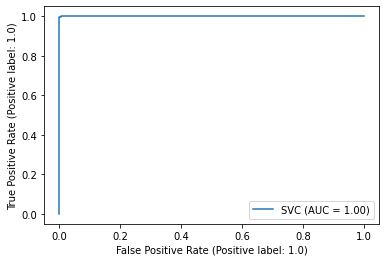

In [7]:
from sklearn import metrics
import matplotlib.pyplot as plt

metrics.plot_roc_curve(SVM, test_x, test_y)  
plt.savefig('out/roc_curve.jpg')

In [8]:
from sklearn.metrics import average_precision_score

score_test = SVM.decision_function(test_x)
average_precision = average_precision_score(test_y, score_test)

print(f"Average Precision Score : {average_precision}")

Average Precision Score : 0.9999772082011692


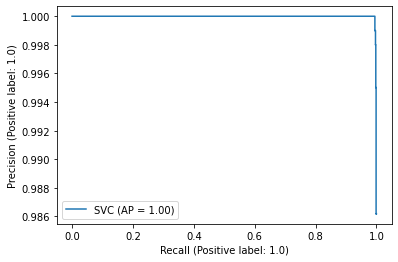

In [9]:
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(SVM, test_x, test_y)
plt.savefig('out/precision_recall_curve.jpg')

### Face Detector Function

This function takes an image as the input, and based on its other hyperparameters, identifies the existing faces in that image and highlights them using bounding boxes.

This function uses sliding windows on different scales of the original image to iterate through all the possible face locations in that image and then uses the previously obtained HOG descriptor and SVM classifier to determine whether a face exists in these locations or not. After this, a non-maximum suppression method is used to eliminate the extra boxes. Finally, all the detected face locations are highlighted using bounding boxes, and the function returns the input image with bounding boxes around the faces inside that image. 

This function is applyed to three pictures inside the `in` folder, and their results are written in the `out` folder.

In [10]:
def FaceDetector(im, score_thresh= 0.97, nms_thresh= 0.6,
                 remove_inner= False, slack = 5, scale= 1.1, stride= 10, SVM= SVM, hog= hog):
    win_size = hog.winSize[0]
    h, w = im.shape[:2]
    bboxes = []
    probs = []
    cur_im = im.copy()
    cur_scale = 1
    print("Start Image Processing:")
    print("Scales:")
    while(cur_im.shape[0] > win_size and cur_im.shape[1] > win_size):
        print(cur_scale)
        h, w = cur_im.shape[:2]
        cur_im = cv2.copyMakeBorder(cur_im, win_size, win_size, win_size, win_size, cv2.BORDER_CONSTANT)
        h1, w1 = cur_im.shape[:2]
        for i in range(0, h1 - win_size, stride):
            for j in range(0, w1 - win_size, stride):
                fd = hog.compute(cur_im[i:i+win_size, j:j+win_size]).reshape(-1)
                prob = SVM.predict_proba([fd])[0][1]
                if prob > score_thresh:
                    bboxes.append(np.array([(j - win_size, i - win_size, j, i)]) * cur_scale)
                    probs.append(prob)
        cur_scale = cur_scale * scale
        cur_im = cv2.resize(im, (int(w/ scale), int(h/ scale)))
        
    bboxes = np.array(bboxes)
    probs = np.array(probs)
    s_box_id = cv2.dnn.NMSBoxes(bboxes, probs, score_thresh, nms_thresh)
    s_boxs = bboxes[s_box_id.reshape(-1)].reshape(-1, 4)
    s_probs = probs[s_box_id.reshape(-1)].reshape(-1)
    if remove_inner:
        rm_boxs = s_boxs.copy().reshape(-1, 4)
        remove_indexs = []
        for bigbox in rm_boxs:
            x, y, x1, y1 = bigbox
            for (i, smallbox) in enumerate(rm_boxs):
                sx, sy, sx1, sy1 = smallbox
                if (bigbox == smallbox).all():
                    continue
                if x - slack < sx and y - slack< sy and sx1 < x1 + slack and sy1 < y1 + slack:
                    remove_indexs.append(i)
        remove_indexs = np.unique(remove_indexs)
        s_boxs = np.delete(s_boxs, remove_indexs, axis = 0)
        s_probs = np.delete(s_probs, remove_indexs, axis = 0)
        
    res_im2 = im.copy()
    for (i, box) in enumerate(s_boxs):
        box = box.astype(int)
        color = np.random.randint(0, 255, 3).tolist()
        color = (color[0], color[1], color[2])
        cv2.rectangle(res_im2, (box[0], box[1]), (box[2], box[3]), color, 3)
        cv2.putText(res_im2, 'score:{:.3f}'.format(s_probs[i]), (box[0], box[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return res_im2

In [11]:
im = cv2.imread("in/Melli.jpg", -1)
melli = FaceDetector(im, 0.97, 0.6)
cv2.imwrite("out/Melli.jpg", melli);

Start Image Processing:
Scales:
1
1.1
1.2100000000000002
1.3310000000000004
1.4641000000000006
1.6105100000000008
1.771561000000001
1.9487171000000014
2.1435888100000016
2.357947691000002
2.5937424601000023
2.853116706110003
3.1384283767210035
3.4522712143931042
3.797498335832415
4.177248169415656
4.594972986357222
5.054470284992944
5.559917313492239


In [12]:
im = cv2.imread("in/Persepolis.jpg", -1)
persepolis = FaceDetector(im, 0.97, 0.6)
cv2.imwrite("out/Persepolis.jpg", persepolis);

Start Image Processing:
Scales:
1
1.1
1.2100000000000002
1.3310000000000004
1.4641000000000006
1.6105100000000008
1.771561000000001
1.9487171000000014
2.1435888100000016
2.357947691000002
2.5937424601000023
2.853116706110003
3.1384283767210035
3.4522712143931042
3.797498335832415
